# Fine-tuning DETR-resnet50 

## 1. Custom CocoDetection 클래스

 torchvision의 CocoDetection 클래스를 상속 \
 DETR 학습에 맞게 커스텀 데이터셋 클래스를 정의

 이미지와 어노테이션을 불러오고, feature_extractor를 통해 DETR 입력 포맷에 맞게 전처리

In [1]:
import torchvision
import os
from torchvision import transforms as T

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, imageprocessor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.imageprocessor = imageprocessor
        self.train = train
        # 학습 시에만 색상/블러 기반의 안전한 증강 적용 (박스 수정 불필요)
        self.augment = (
            T.Compose([
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
                T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
                T.RandomAutocontrast(p=0.2),
                T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),
            ])
            if train
            else None
        )

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # 학습 시 이미지 컬러/블러 증강 (기하 변환 없음 → 박스 수정 불필요)
        if self.augment is not None:
            img = self.augment(img)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.imageprocessor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return pixel_values, target

In [2]:
from transformers import DetrImageProcessor 
import autorootcwd

img_folder = "data/coco_lp"

imageprocessor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=f'{img_folder}/train', imageprocessor=imageprocessor)
val_dataset = CocoDetection(img_folder=f'{img_folder}/val', imageprocessor=imageprocessor, train=False)

c:\Users\User\Desktop\smart-farm\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [3]:
len(train_dataset)

20

In [4]:
len(val_dataset)

5

In [5]:
pixel_values, target = train_dataset[10]

In [26]:
# 
target

{'size': tensor([1333,  749]), 'image_id': tensor([11]), 'class_labels': tensor([0]), 'boxes': tensor([[0.4400, 0.5210, 0.2987, 0.0465]]), 'area': tensor([13859.1729]), 'iscrowd': tensor([0]), 'orig_size': tensor([667, 375])}

---

## 2. Dataset 시각화 with fiftyone

In [35]:
import fiftyone as fo
from pathlib import Path

# --- 설정 ---
# 시각화하고 싶은 데이터 스플릿을 여기에 지정하세요 (예: 'train', 'val', 'test')
SPLIT_TO_VISUALIZE = 'train'

# 데이터셋 경로 설정 (기존 img_folder 변수 사용)
data_path = Path(img_folder) / SPLIT_TO_VISUALIZE
anno_path = data_path / "custom_train.json"

# FiftyOne 데이터셋 이름 설정
#dataset_name = "tomato-detr-dataset"
dataset_name = "coco_lp-detr-dataset"

# --- 데이터셋 로드 및 시각화 ---

# 기존에 같은 이름의 데이터셋이 있다면 삭제
if dataset_name in fo.list_datasets():
    fo.delete_dataset(dataset_name)

# COCO 형식의 데이터셋을 FiftyOne으로 로드
# data_path: 이미지 파일들이 있는 폴더
# labels_path: COCO JSON 어노테이션 파일
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=anno_path,
    name=dataset_name,
)

# FiftyOne App 실행
print("Launching FiftyOne App. Press Ctrl+C in the terminal to exit.")
session = fo.launch_app(dataset, auto=False)
session.show()

 100% |███████████████████| 20/20 [132.2ms elapsed, 0s remaining, 151.2 samples/s] 
Launching FiftyOne App. Press Ctrl+C in the terminal to exit.
Session launched. Run `session.show()` to open the App in a cell output.


---

## 3. DataLoader 생성

collate_fn() : 
- 배치 데이터를 처리하는 함수  
- 배치 내 이미지와 어노테이션을 텐서로 변환하고, 패딩 처리, 레이블 정렬 등을 수행

In [28]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = imageprocessor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True, num_workers=0)

In [29]:
batch = next(iter(train_dataloader))

batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

---

In [30]:
from transformers import DetrImageProcessor 
import autorootcwd

img_folder = "data/coco_lp"

imageprocessor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=f'{img_folder}/train', imageprocessor=imageprocessor)
val_dataset = CocoDetection(img_folder=f'{img_folder}/val', imageprocessor=imageprocessor, train=False)

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## 4. PyTorch Lightning 모델 정의

In [31]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision


class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay
         self.map_metric = MeanAveragePrecision(box_format='cxcywh', iou_type='bbox', class_metrics=False)
         self.score_threshold = 0.5

     def _update_map(self, outputs, labels):
         """Convert DETR outputs + HF labels to torchmetrics format and update mAP."""
         probs = outputs.logits.softmax(-1)[..., :-1]
         scores, pred_labels = probs.max(-1)
         pred_boxes = outputs.pred_boxes

         preds, tgts = [], []
         B, Q, _ = pred_boxes.shape
         for i in range(B):
            keep = scores[i] > self.score_threshold
            preds.append({
                  "boxes": pred_boxes[i][keep].detach().cpu(),
                  "scores": scores[i][keep].detach().cpu(),
                  "labels": pred_labels[i][keep].detach().cpu(),
            })
         for t in labels:
            tgts.append({
                  "boxes": t["boxes"].detach().cpu(),
                  "labels": t["class_labels"].detach().cpu(),
            })

         if len(preds) > 0:
            self.map_metric.update(preds, tgts)

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        with torch.no_grad():
         labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]
         outputs = self.model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])
         self._update_map(outputs, labels)

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

     def on_validation_epoch_end(self):
         metrics = self.map_metric.compute()  # dict
         for k, v in metrics.items():
            if isinstance(v, (int, float)):
                  self.log(f"val_{k}", v, prog_bar=True)
                  continue

            if torch.is_tensor(v) and v.ndim == 0:
                  self.log(f"val_{k}", v, prog_bar=True)
                  continue

            if torch.is_tensor(v) and v.ndim > 0 and v.numel() > 0:
                  if k.endswith("_per_class"):
                     self.log(f"val_{k}_mean", v.float().mean(), prog_bar=False)
                  # 'classes' 같은 정수 라벨 벡터는 로그 생략
                  continue
         self.map_metric.reset()

In [32]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

c:\Users\User\Desktop\scratch_DETR\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\User\Desktop\scratch_DETR\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\User\Desktop\scratch_DETR\.venv\Lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in 

In [34]:
import torch
torch.set_float32_matmul_precision('mideum')  # TF32
from pytorch_lightning import Trainer

model.train()
trainer = Trainer(accelerator="gpu", max_steps=200, gradient_clip_val=0.1)
trainer.fit(model)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | model      | DetrForObjectDetection | 41.5 M | train
1 | map_metric | MeanAveragePrecision   | 0      | train
--------------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.007   Total estimated model params size (MB)
400       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

In [37]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [38]:
def visualize_predictions(image, outputs, threshold=0.9, keep_highest_scoring_bbox=False):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  if keep_highest_scoring_bbox:
    keep = probas.max(-1).values.argmax()
    keep = torch.tensor([keep])

  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [39]:
it = iter(range(1500))

In [40]:
it

torch.Size([1, 3, 1333, 750])


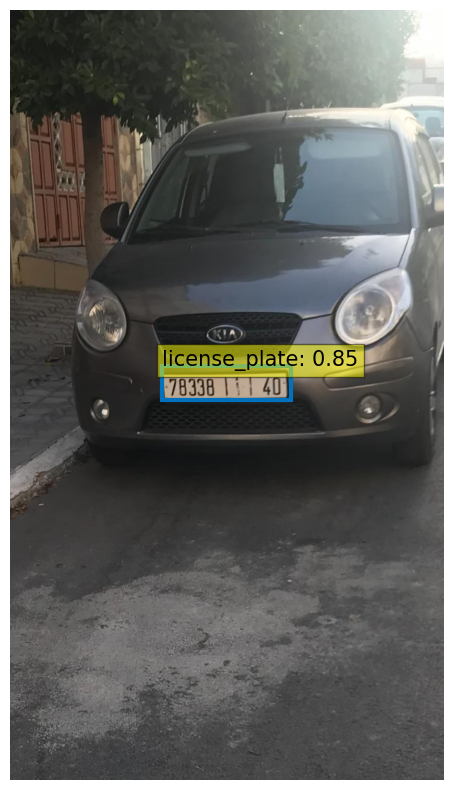

In [44]:
#We can use the image_id in target to know which image it is
from PIL import Image

pixel_values, target = train_dataset[next(it)]

pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)

image_id = target['image_id'].item()
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{img_folder}/train', image['file_name']))

visualize_predictions(image, outputs, threshold=0.5, keep_highest_scoring_bbox=False)